In [2]:
using DataFrames, CSV, XLSX
using Optim
using PyPlot
using Test

In [3]:
fname = "Auswertung_5.xlsx"

f = XLSX.readxlsx(fname)

XLSXFile("Auswertung_5.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
               Blatt1 136x4         A1:D136      


In [4]:
car1 = DataFrame(XLSX.readtable(fname, "Blatt1", "A:B", 
        column_labels = ["time", "pos"],
        infer_eltypes = true
            )...)
first(car1, 4)

,time,pos
,Any,Float64
1,0,-0.00156917
2,0.0333333,0.0125462
3,0.0666667,0.0267485
4,0.1,0.0406588


In [5]:
car1.time = float.(car1.time)
first(car1, 4)

,time,pos
,Float64,Float64
1,0.0,-0.00156917
2,0.0333333,0.0125462
3,0.0666667,0.0267485
4,0.1,0.0406588


In [6]:
car2 = DataFrame(XLSX.readtable(fname, "Blatt1", "C:D", 
        column_labels = ["time", "pos"],
        infer_eltypes = true
            )...)
first(car2, 4)

,time,pos
,Any,Float64
1,0,0.803284
2,0.0333333,0.803497
3,0.0666667,0.803732
4,0.1,0.803757


In [7]:
car2.time = float.(car2.time)
first(car2, 4)

,time,pos
,Float64,Float64
1,0.0,0.803284
2,0.0333333,0.803497
3,0.0666667,0.803732
4,0.1,0.803757


In [13]:
filter!(row -> row.time < 1.8, car1 );
filter!(row -> row.time < 1.8, car2 );

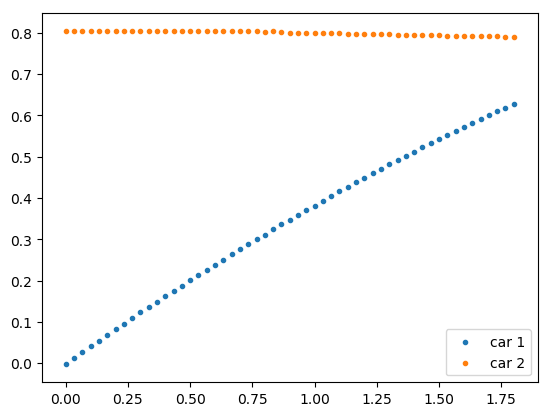

PyObject <matplotlib.legend.Legend object at 0x91b1fb30>

In [14]:
scatter(car1.time, car1.pos, label = "car 1", marker =".")
scatter(car2.time, car2.pos, label = "car 2", marker =".")
legend()

In [ ]:
function two_piece_linear(x, para)
    n   = para[1]
    m1  = para[2]
    m2  = para[3]
    x12 = para[4]
    if x < x12
        n + m1 * x
    else
        n + m1 * x12 + m2 * (x - x12)
    end
end

In [9]:
function linear_interpolation(x1, y1, x2, y2, x)
    @assert x1 != x2
    m = (y2-y1)/(x2-x1)    # slpoe
    y = y1 + m * (x-x1)    # 
    return(y)
end

linear_interpolation (generic function with 1 method)

In [10]:
@testset "linear_interpolation" begin
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 0.0) == 9 
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 1.0) == 10 
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 1.5) == 10.5
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 2.0) == 11
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 3.0) == 12
end;

Test Summary:        | Pass  Total
linear_interpolation |    5      5


In [11]:
function sum_residuals_squared(obs_data, obs_colx, obs_coly, 
          mod_data, mod_colx, mod_coly)
    
    # make sure everythin is in right order
    sort!(obs_data, obs_colx)
    sort!(mod_data, mod_colx)
    
    # make sure that there is enough data
    @assert mod_data[1,              mod_colx] <= obs_data[1,              obs_colx]
    @assert mod_data[nrow(mod_data), mod_colx] >  obs_data[nrow(obs_data), obs_colx]
    
    # sum of residuals squared
    srs = 0.0
    
    mk = 1
    for row in eachrow(obs_data)
        x = row[obs_colx]
        
        mk = findnext(mx -> mx > x, mod_data[!, mod_colx], mk)
        @assert !isnothing(mk) && mk >= 2
        
        x1 = mod_data[mk-1, mod_colx]
        y1 = mod_data[mk-1, mod_coly]
        x2 = mod_data[mk  , mod_colx]
        y2 = mod_data[mk  , mod_coly]

        y = linear_interpolation(x1, y1, x2, y2, x)
        
        srs += (row[obs_coly] - y)^2
    end
    
    srs
end

sum_residuals_squared (generic function with 1 method)

In [12]:
@testset "sum_residuals_squared" begin 
    L = 10000
    t = rand(L)
    mod = DataFrame(t = t, x = t)
    
    t = 0.5 .* rand(L) .+ 0.25 
    obs = DataFrame(t = t, x = t)
    @test sum_residuals_squared(obs,"t", "x", mod, "t", "x") == 0
    
    t = 0.5 .* rand(L) .+ 0.25 
    obs = DataFrame(t = t, x = t .+ 1.0)
    @test sum_residuals_squared(obs,"t", "x", mod, "t", "x") == L
    
    t = 0.5 .* rand(L) .+ 0.25 
    obs = DataFrame(a = t, b = t .- 2.0)
    @test sum_residuals_squared(obs, "a", "b", mod, "t", "x") == 4 * L
end;

Test Summary:         | Pass  Total
sum_residuals_squared |    3      3


# Friction - 1d

In [140]:
para = [0, 0.5, 0.5]

3-element Array{Float64,1}:
 0.0
 0.5
 0.5

In [17]:
function data_model(x1, x2, v1, v2, μ1, µ2)
    tend = 2
    dt = 0.001

    data = DataFrame(t = 0.0, x1 = float(x1), x2 = float(x2), v1 = float(v1), v2 = float(v2))

    while true
        state = data[nrow(data),:]

        f1_friction = - μ1 * state.v1 

        t = state.t + dt
        x1 = state.x1 + state.v1 * dt
        v1 = state.v1 + f1_friction * dt

        f2_friction = - μ2 * state.v2 

        x2 = state.x2 + state.v2 * dt
        v2 = state.v2 + f2_friction * dt



        push!(data, (t, x1, x2, v1, v2))
        t >= tend && break
    end
    
    data
end

data_model (generic function with 1 method)

In [33]:
function likelihood(parameter)
    ^mod = data_model(parameter...)
    s1 = sum_residuals_squared(car1, "time", "pos", mod, "t", "x1")
    s2 = sum_residuals_squared(car2, "time", "pos", mod, "t", "x2")
    s1 + s2
end

likelihood (generic function with 1 method)

In [34]:
@show res = optimize(likelihood, para)
para = Optim.minimizer(res)

res = optimize(likelihood, para) =  * Status: success

 * Candidate solution
    Minimizer: [-2.58e-03, 8.07e-01, 4.32e-01,  ...]
    Minimum:   1.677088e-04

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [0.00e+00, 8.00e-01, 3.50e-01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    251
    f(x) calls:    425



6-element Array{Float64,1}:
 -0.0025776310655239087
  0.807171754405974
  0.43231945326044424
 -0.007035200463812572
  0.2401727478048489
 -0.2694659638663359

In [30]:
#para = [0.0, 0.8, 0.35, 0.0, 0.001, 0.001]

6-element Array{Float64,1}:
 0.0
 0.8
 0.35
 0.0
 0.001
 0.001

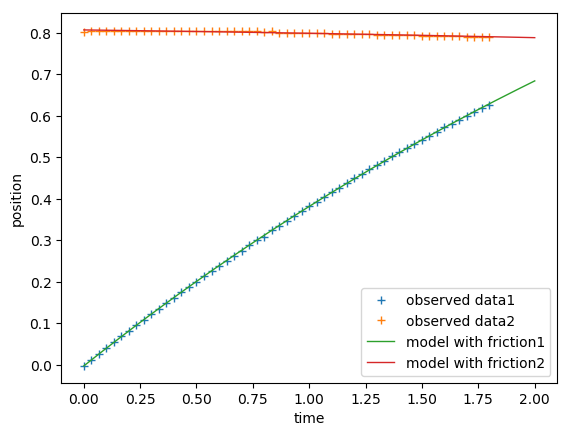

In [35]:
plot(car1.time,  car1.pos  ,linewidth = 0, marker = "+", label="observed data1")
plot(car2.time,  car2.pos  ,linewidth = 0, marker = "+", label="observed data2")



mod = data_model(para ...)
plot(mod.t, mod.x1 ,linewidth = 1,label="model with friction1")
plot(mod.t, mod.x2 ,linewidth = 1,label="model with friction2")


xlabel("time")
ylabel("position")
legend();

In [56]:
function data_model_coll(x1, x2, v1, v2, μ1, µ2, s, D)
    tend = 4.6
    dt = 0.0001

    data = DataFrame(t = 0.0, x1 = float(x1), x2 = float(x2), v1 = float(v1), v2 = float(v2))

    while true
        state = data[nrow(data),:]

        f1_friction = - μ1 * state.v1 

        t = state.t + dt
        x1 = state.x1 + state.v1 * dt
        v1 = state.v1 + f1_friction * dt

        f2_friction = - μ2 * state.v2 

        x2 = state.x2 + state.v2 * dt
        v2 = state.v2 + f2_friction * dt
        
         d = abs(state.x1 - state.x2) 
        if d > s
            f = 0
        else
            f = D * (s - d)
        end

        v1 = v1 - f * dt
        v2 = v2 + f * dt
        
        push!(data, (t, x1, x2, v1, v2))
        t >= tend && break
    end
    
    data
end

data_model_coll (generic function with 1 method)

In [57]:
fname = "Auswertung_5.xlsx"

f = XLSX.readxlsx(fname)

XLSXFile("Auswertung_5.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
               Blatt1 136x4         A1:D136      


In [58]:
car1 = DataFrame(XLSX.readtable(fname, "Blatt1", "A:B", 
        column_labels = ["time", "pos"],
        infer_eltypes = true
            )...)
first(car1, 4)

,time,pos
,Any,Float64
1,0,-0.00156917
2,0.0333333,0.0125462
3,0.0666667,0.0267485
4,0.1,0.0406588


In [59]:
car1.time = float.(car1.time)
first(car1, 4)

,time,pos
,Float64,Float64
1,0.0,-0.00156917
2,0.0333333,0.0125462
3,0.0666667,0.0267485
4,0.1,0.0406588


In [60]:
car2 = DataFrame(XLSX.readtable(fname, "Blatt1", "C:D", 
        column_labels = ["time", "pos"],
        infer_eltypes = true
            )...)
first(car2, 4)

,time,pos
,Any,Float64
1,0,0.803284
2,0.0333333,0.803497
3,0.0666667,0.803732
4,0.1,0.803757


In [61]:
car2.time = float.(car2.time)
first(car2, 4)

,time,pos
,Float64,Float64
1,0.0,0.803284
2,0.0333333,0.803497
3,0.0666667,0.803732
4,0.1,0.803757


para = [-0.0025776310655239087, 0.807171754405974,
        0.43231945326044424, -0.007035200463812572,
        0.2401727478048489, -0.2694659638663359, 
        0.07, 110]

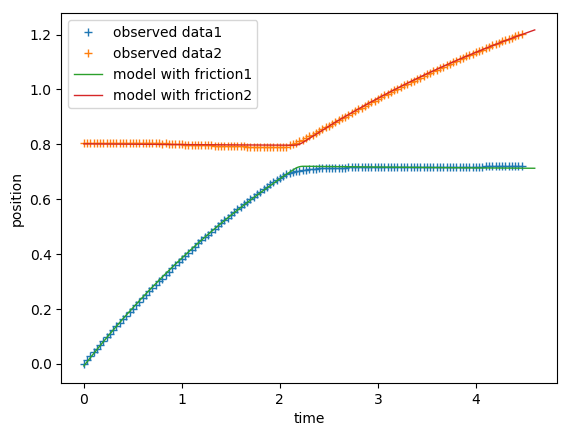

In [66]:
plot(car1.time,  car1.pos  ,linewidth = 0, marker = "+", label="observed data1")
plot(car2.time,  car2.pos  ,linewidth = 0, marker = "+", label="observed data2")



mod = data_model_coll(para ...)
plot(mod.t, mod.x1 ,linewidth = 1,label="model with friction1")
plot(mod.t, mod.x2 ,linewidth = 1,label="model with friction2")


xlabel("time")
ylabel("position")
legend();

In [64]:
function likelihood(parameter)
    mod = data_model_coll(parameter...)
    s1 = sum_residuals_squared(car1, "time", "pos", mod, "t", "x1")
    s2 = sum_residuals_squared(car2, "time", "pos", mod, "t", "x2")
    s1 + s2
end

likelihood (generic function with 1 method)

In [65]:
@show res = optimize(likelihood, para)
para = Optim.minimizer(res)

res = optimize(likelihood, para) =  * Status: success

 * Candidate solution
    Minimizer: [-8.54e-03, 8.02e-01, 4.57e-01,  ...]
    Minimum:   4.644714e-03

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [-2.58e-03, 8.07e-01, 4.32e-01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   459  (vs limit Inf)
    Iterations:    520
    f(x) calls:    830



8-element Array{Float64,1}:
  -0.008536094731095303
   0.8016333715559509
   0.45748018894399234
  -0.003180490232499336
   0.3088163293220593
   0.2604596126978176
   0.09172230831998932
 293.3972032815153

In [71]:
mod = data_model_coll(para ...)
mod.p = mod.v1 .+ mod.v2;
mod.e = mod.v1.^2 .+ mod.v2.^2;

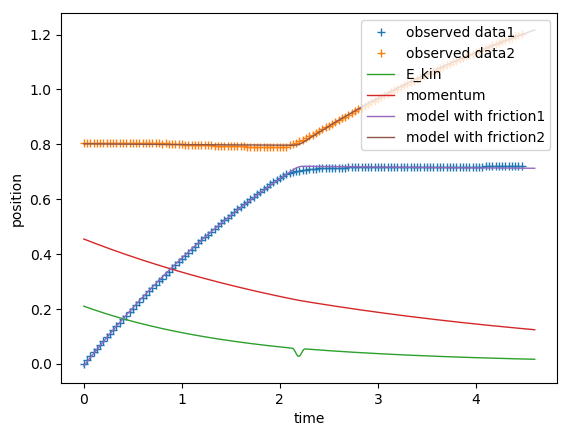

In [74]:
plot(car1.time,  car1.pos  ,linewidth = 0, marker = "+", label="observed data1")
plot(car2.time,  car2.pos  ,linewidth = 0, marker = "+", label="observed data2")


plot(mod.t, mod.e, linewidth = 1, label="E_kin" )
plot(mod.t, mod.p, linewidth = 1, label="momentum")
plot(mod.t, mod.x1 ,linewidth = 1,label="model with friction1")
plot(mod.t, mod.x2 ,linewidth = 1,label="model with friction2")


xlabel("time")
ylabel("position")
legend();

In [75]:
using PyPlot
using PyCall
using Base64
using Printf

anim = pyimport("matplotlib.animation")

function showanim(filename)
    base64_video = Base64.base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

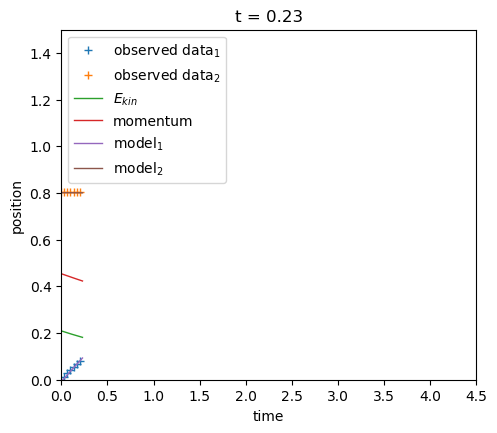

In [87]:
fig = figure(figsize=[5, 5])
    
w1 = 0.1
w2 = 0.02


function animate(i)
    fig.clf()
    ax = fig.add_axes([0.15, 0.15, 0.83, 0.7])
    ax.set_xlim(0, 4.5)
    ax.set_xlabel("time")
    ax.set_ylim(0, 1.5)
    ax.set_ylabel("position")


    last_row_to_plot = floor(Int, nrow(mod) * i/200) 
        if last_row_to_plot == 0 
            last_row_to_plot = 1
        end 
    
    t = mod[last_row_to_plot, "t"]
    t_str = @sprintf "%.2f" t
    ax.set_title("t = $t_str")

    car1t = filter(r -> r.time <= t, car1)
    car2t = filter(r -> r.time <= t, car2)
    modt  = filter(r -> r.t <= t, mod)


    
    
    ax.plot(car1t.time,  car1t.pos  ,linewidth = 0, marker = "+", label="observed data\${}_{1}\$")
    ax.plot(car2t.time,  car2t.pos  ,linewidth = 0, marker = "+", label="observed data\${}_{2}\$")


    ax.plot(modt.t, modt.e,  linewidth = 1, label="\$E_{kin}\$" )
    ax.plot(modt.t, modt.p,  linewidth = 1, label="momentum")
    ax.plot(modt.t, modt.x1 ,linewidth = 1, label="model\${}_{1}\$")
    ret = ax.plot(modt.t, modt.x2 ,linewidth = 1, label="model\${}_{2}\$")
    ax.legend(loc = 2)
    
    ret
    
end

animate(10);

In [88]:
frames = 200

myanim = anim.FuncAnimation(fig, animate, frames=frames, interval=25, blit=true)
myanim.save("2Wagen.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

showanim("2Wagen.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAoUZtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NSByMjkxNyAwYTg0ZDk4IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxOCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAcN2WIhAAz//727L4FNf2f0JcRLMXaSnA+KqSAgHc0wAAAAwAAAwAk5xzESl9th2YAAAMBRAAZQ+/p0ivEfgAayGN13dBk5n1RBnmD5CzWevmgIf3O4kHpP9Xxu891nKHA3pgdg5OLWlzh/dxlNBHlDMjfHWE5OoQEkscAZZy8G5JYYMNWD2aY9y1RErXjoyk6qG9HOVSK37mVcFpimCDQ/geezFE7LaHZCVGQs0musAcMoiXP3DavBQblNKDhVW3R3RWr7S0eVnGPELWVi00/ep+8VrYix6U79dQxagr1k/uYT08nEWEKHYUc60y72sZzg6HxVBFF0CSU0D8hMvP6Zdcd8mcKdKsWoHAnruVT2SkNfbfaNfBornxW66qCAA1tDpHEwoA9qUg8xMCN/RYlAoWLknEhB1rIgpPxzovUiG28yjkj/J7xpcNEqUFx8dJJes1n7BNiwpN2CZla+s4sFrOW6YogLPOszQaLyy9pQFWr2a/drhDBJcdd12fPly6YfBehI40H758vxCEoKZ8tPohrqeVl6c8aGJsHe5SDQP8yZwm95s9MTSlMTSS2Tl81tY299DPSBmwkyGQzx5ce8qdmEco6d7vE2LpYTtO/9lbTCafQ5GZ2yn6qkqZnvP24NPL5qr7h1S95089abfdErDJtkRCbgqxqgK59RRwirrFM0dyn+HYSm4fGuUmguXUKjUocKkNH6EDNgSG9oaEp70Min36jRlQQY7ewAMoGjGOGc/qU0WinWWagpNAYC+JgC5isNOTvGH+2D+A/13sXDTWAwfzvay+i8NcuxKPSYaVmOPXQzVLEDxXcFPKsncgrvB3WgCvEoPNCho/EXauJqaIjZxqrR/PRBI1r1MK1EykSygykb/iVOczjKbaGYA97g/MWFCnv2W+3BIIW+1yJVszN2AOVQ0CdYYqEvogZNNYKUuHBko+JyuKCOx/QxBpRQZJZsUVTQ1sONeYGwKkTYn9QB8Fi+ZBNA3/Xxrskp/06x7M8+wDqPqaqBLzpAZoXwf6LoImf4XPSmMkVnZhtrh85V3ImHTQV23uTlhGNPGik/LHdboN4pKLYmJBXFvyDbqGl9u3EIrl+Ja+J9Ba8kw1Pdk9n6qljH75NlE2qv/5gpq8IAi86Jjcb7mPLw3Ia7eNrel7rKe7ZmUACBEn78P+zAsQxHGDnTdaNgVuWs0x+Q2pBC+kqPBengBsQkCHotMn5QNrlkIaLq7ZTlw+afx6Exo4qd2RQ7Aegr78nSQs0W5RlYazT0ERDPnu2SDadjeIEleJiC96QtiH+J4ap8dTHg7msDnG52w7znfQ0QH1c0P1VDANIJQNxpzcC4C4jxHAvBNIoUjHD1XK6RQ0z7nyjHPbxQB9LnY0L2/Aj8TXzBQ11DF9I6+PSbfMJvFcd4L8dInYeawBY7fe3kobzDm5MTrW3z0zgGD7OuFvwqp2fbTX2PWWJH3lLdtMSj5BdtzrwhxKxxhlvJJJGA14FGNOOA2PtIE/ZF5DyGhBsCipd7YQyuUYKRhMfd15S/TA6y2AmYhZ5fK/Lco+Off3LhXMi7R445H9pt6wTc2Vk5fp7wcRwqxRUTMMofGw80d/kS2S2lEteEV2iSq68nHg0+FeWwJru6syv8RmL1WUwvTgHh01942SrrKoDnM83MvQD9WMoCxEPZLDZBxfkvpYfyP8dNLrxWvyeaa7pAsYXjYO/R/s2uNUoy21Pf42qsNyx+UaTAaixmAFMsd9lxRUOevZGPnYsyh8jUhOBjHA/chJ2254zg1W5da0rZM6unX9icj1DBXUAAP7v8M2N+QHPQqgb/r97h56uK+uS3VVwFCHNLB7xD2OeCisoE5Wa1c/QCFNb3P3B2IPJOvU4gET3rXWtn37B3wn6E7Ev0GvXYfsEBU6fwlDIkZGCKguVgA5gQ9grm+jcVbbR/UcgKvp0LDjAWaabeh/gY0yj8kZHYr7DQeIklgsqJ5B5/VDu1vKj5e8qHQcF3WIa5rfiyx9HRThlOulCqkOqnDXubyUgtnbSkrUxQJGbujHjcvq5UvSaaFkCyp0bcXrMiMJyVdtHDcVyJzccJfRXyhvgpb5S+1+PdU/uLkf/Tdssaq62xp4mE02rAfoZO5AE7cEIK2V2koXFLkB21e3AwF1JQTbFBfXqBbQFQw7PmdZ9uism3SAWQGsour7xNDY8arF92kfZzjNPL2eFWfb4oIdwa07H3sn/SXSKNTtVvSvSUg1OnJh38qG+BAzyGv2PxoxptovGcmvxQpAwbpAewoh9CFtbP2YtCen+8LNFLGoHGcM1tlbC11seRUdUrw6J/tXYCx1f4NtA3J9uuaO0M4M8FV9fhv75WgK5ddyvSqLTzFmu0+x+wgT2sslfecazuRzroIhfvpLqEurIxjqFUPiKn9bJhczsy/gYTZ3CocDPzMCh8kaRiNYFGWg7zgQNGsEzavrSVXSpEX2vP3yDO1MYnezzean6lzQWwI/wQbPjhz2HOuiJYJUte0fH2cqPEXH3mNIlo1h7m+HiFpFm5UYGExNchYLnzfpDBQRyqlPH2etV6cgkiSAe4Ki2fqCo8kBDePi4sik5YiciGnGDMyBjcbZAhkM7FWCA+KtUToFC64wkkUyM0yWwQXJ9PGJdVIAABvdJZmspH/F4bCDo8xoJtd4csn2xXBmGHnb00LhUIpr6IByfyJJRPfDQLIc4Ic73zwND4hAL7l+//gT869Z0/4vTqr+Zcif8FQoZwNU7k9hihNk9JzIkvjVAo2mNefCSAI3bGQX7k3FTa1Ur/jtEyg4rtiXnJIRJWfXUaM3/TcItppRgv1925x1r5D+083rEk8YOfnHE/89/KUR3hfYGHj2ZAHpBTadq7ca0V1RhphV2BW/TUfftkecuJ+bmdtSvS7c2amdKmvL4FIA9Ih5xe6DFY4SS5Gv3edMqspReIgp/8gcbErck5HlRJGqqsROEC9AyzyU